In [0]:
#import all the essentials 

import numpy as np
import pandas as pd
import nltk 
nltk.download("popular")
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import cross_validate,RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from math import sqrt
from nltk.stem.snowball import SnowballStemmer
import time
!pip install fuzzywuzzy #pip install fuzzywuzzy 
from fuzzywuzzy import fuzz
import sklearn.feature_extraction.text as sktf
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn import linear_model
from xgboost import XGBClassifier
import xgboost

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [0]:
#start time 
start = time.time()

In [0]:
#load data into dataframes
df_train_data = pd.read_csv('/content/drive/My Drive/IHU/NLP/Coursework/data/train.csv', encoding="ISO-8859-1")
df_test_data = pd.read_csv('/content/drive/My Drive/IHU/NLP/Coursework/data/test.csv', encoding="ISO-8859-1")
df_pro_desc_data = pd.read_csv('/content/drive/My Drive/IHU/NLP/Coursework/data/product_descriptions.csv',encoding='ISO-8859-1')
df_attr = pd.read_csv('/content/drive/My Drive/IHU/NLP/Coursework/data/attributes.csv',encoding='ISO-8859-1')

#keep the number of lines for train tupples
#in order to split them again later 
num_train = df_train_data.shape[0]

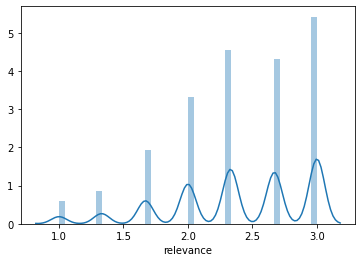

In [0]:
#Relevance unique values and frequency
sns.distplot(df_train_data.relevance)

In [0]:
#Create brand dataframe from attributes.csv
df_brand = df_attr[df_attr.name == "MFG Brand Name"][["product_uid", "value"]].rename(columns={"value": "brand"})
df_brand['brand'] = df_brand['brand'].replace(np.nan," ")

In [0]:
#Create material dataframe from attributes.csv
df_material = df_attr[df_attr.name == "Material"][["product_uid", "value"]].rename(columns={"value": "material"})
df_material['material'] = df_material['material'].replace(np.nan," ")

#Remove duplicate rows regarding product_uid since attributes.csv
#contains for 818 products duplicate records for "Material" attribute
df_material = df_material.drop_duplicates(subset='product_uid', keep='first')

In [0]:
#Create a bullets dataframe which combines the bullets from attributes.csv

#list with names of the attributes Bullet01 to Bullet22
#Bullet22 is the max bullet attribute found in this dataset
bullet_list = []
for i in range (1,23):
  if i<10:
    i = '0'+str(i)
  bullet_list.append('Bullet'+str(i))

#Keep only the rows with the bullet attribute for each product_uid
df_bullets_rows = df_attr[df_attr.name.isin(bullet_list)][["product_uid",'name', "value"]]

#transpose the dataframe so Bullet rows become Columns 
#every row now is the product with its values for every bullet (if any)
#fillna with the empty string since not all prodcuts have values in all the bullets
df_bullets_t = (df_bullets_rows.pivot(index='product_uid', columns='name', values='value')
                                .fillna(' ').reset_index())

#create a column which aggreagates all bullets to one column 
df_bullets_t['bullets'] = df_bullets_t[bullet_list].agg(' '.join, axis=1)

#keep only the combined 
df_bullets = df_bullets_t.filter(['product_uid','bullets'], axis=1)

In [0]:
#Load ready-dictionary which checks spelling for search terms
spell_check_dict= {}

with open("/content/drive/My Drive/IHU/NLP/Coursework/data/spelling_dictionary.txt") as f:
  for line in f:
    spell_check_dict[str(line.split(":")[0])] = str(line.split(":")[1]).strip("\n")

In [0]:
#Word Embeddings

#Load the simiiratity of following mean vectors pairs:
#search term & product title
#search term & product desscription
#search term & bullets.
#For more info check the "word embeddings.ipynb"

df_vectors = pd.read_csv('/content/drive/My Drive/IHU/NLP/Coursework/data/vector_similarity.csv')

In [0]:
#Get a taste of the data 
for i in [df_train_data,\
          df_test_data,\
          df_pro_desc_data,\
          df_attr,\
          df_brand,\
          df_bullets]:\
          display(i.head(3),i.shape,i.isnull().sum())
          

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.0
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.5
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.0


(74067, 5)

id               0
product_uid      0
product_title    0
search_term      0
relevance        0
dtype: int64

,id,product_uid,product_title,search_term
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able


(166693, 4)

id               0
product_uid      0
product_title    0
search_term      0
dtype: int64

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...


(124428, 2)

product_uid            0
product_description    0
dtype: int64

,product_uid,name,value
0,100001.0,Bullet01,Versatile connector for various 90Â° connectio...
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001.0,Bullet03,Help ensure joints are consistently straight a...


(2044803, 3)

product_uid     155
name            155
value          2284
dtype: int64

,product_uid,brand
9,100001.0,Simpson Strong-Tie
37,100002.0,BEHR Premium Textured DeckOver
69,100003.0,STERLING


(86250, 2)

product_uid    0
brand          0
dtype: int64

name,product_uid,bullets
0,100001.0,Versatile connector for various 90Â° connectio...
1,100002.0,"Revives wood and composite decks, railings, po..."
2,100003.0,Slightly narrower for tighter spaces Designed ...


(86263, 2)

name
product_uid    0
bullets        0
dtype: int64

In [0]:
#Functions 


#regular expresions, stop words removal and stemmer
stemmer = SnowballStemmer('english')
stop_words = set(stopwords.words('english')) 

def str_cleaner_stemmer(s):
    s_clean = (re.sub(r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)'," ", s))
    return " ".join([stemmer.stem(word) for word in s_clean.lower().split() if word not in stop_words])

#count number of common words
def str_common_word(s1, s2):
	return sum(int(s2.find(word)>=0) for word in s1.split())
 
#fuzzy logic ratio
def fuzzy_WRatio(s1,s2):
    return fuzz.WRatio(s1,s2)/100
  
 
#function for spell checking with the predefined dictionary
def spell_check(text):
    for key in spell_check_dict:
        text = text.replace(key, spell_check_dict[key])
    return text

#Jaccard similarity 
def jaccard_similarity(s1,s2):
    set1 = set(s1.split())
    set2 = set(s2.split())
    if len(set1.union(set2))!=0:
      j_sim = len(set1.intersection(set2)) / len(set1.union(set2))
    else:
      j_sim = 0
    return j_sim


#Cosine similarity
def dist_cosine(data,col1,col2):   
    cos=[]
    for i in range(len(data.id)):        
        st=data[col1][i]
        title=data[col2][i] 
        if len(title)!=0:       
          tfidf = sktf.TfidfVectorizer().fit_transform([st,title])
          c=((tfidf * tfidf.T).A)[0,1]
        else:
          c=0       
        cos.append(c)                                   
    return cos

#Check if the whole search term exists in another string
def str_whole_word(substring, big_string):
  return len(re.findall(substring, big_string))

In [0]:
#Concat the train and test data in on DF for efficiency 
#Be carefull sort must be false in order to maintain the correct order

df_all = pd.concat((df_train_data, df_test_data), axis=0, ignore_index=True, sort = False)

#Merge with product description on product uid 
df_all = pd.merge(df_all, df_pro_desc_data, how='left', on='product_uid')

#Merge with brand on prodcuct uid
df_all = pd.merge(df_all, df_brand, how='left', on='product_uid')
df_all['brand'] = df_all['brand'].replace(np.nan," ")

# #Merge with material on product uid
df_all = pd.merge(df_all, df_material, how='left', on='product_uid')
df_all['material'] = df_all['material'].replace(np.nan," ")

# Merge with bullets on product uid
df_all = pd.merge(df_all, df_bullets, how='left', on='product_uid')
df_all['bullets'] = df_all['bullets'].replace(np.nan," ")

In [0]:
#Spell Check
df_all['search_term'] = df_all['search_term'].map(lambda x:spell_check(str(x)))

In [0]:
#Data Preprocess
#Perform Cleaning and Stemming at string fields

df_all['search_term'] = df_all['search_term'].map(lambda x:str_cleaner_stemmer(x))
df_all['product_title'] = df_all['product_title'].map(lambda x:str_cleaner_stemmer(x))
df_all['product_description'] = df_all['product_description'].map(lambda x:str_cleaner_stemmer(x))
df_all['brand'] = df_all['brand'].map(lambda x:str_cleaner_stemmer(x))
df_all['material'] = df_all['material'].map(lambda x:str_cleaner_stemmer(x))
df_all['bullets'] = df_all['bullets'].map(lambda x:str_cleaner_stemmer(x))

In [0]:
df_all

,id,product_uid,product_title,search_term,relevance,product_description,brand,material,bullets
0,2,100001,simpson strong tie 12 gaug angl,angl bracket,3.00,angl make joint stronger also provid consist s...,simpson strong tie,galvan steel,versatil connector various 90 connect home rep...
1,3,100001,simpson strong tie 12 gaug angl,l bracket,2.50,angl make joint stronger also provid consist s...,simpson strong tie,galvan steel,versatil connector various 90 connect home rep...
2,9,100002,behr premium textur deckov 1 gal sc 141 tugboa...,deck,3.00,behr premium textur deckov innov solid color c...,behr premium textur deckov,,reviv wood composit deck rail porch boat dock ...
3,16,100005,delta vero 1 handl shower faucet trim kit chro...,rain shower head,2.33,updat bathroom delta vero singl handl shower f...,delta,,includ trim kit rough kit r10000 unbx sold sep...
4,17,100005,delta vero 1 handl shower faucet trim kit chro...,shower faucet,2.67,updat bathroom delta vero singl handl shower f...,delta,,includ trim kit rough kit r10000 unbx sold sep...
...,...,...,...,...,...,...,...,...,...
240755,240756,224424,stufurhom norma 24 w x 16 x 34 h linen storag ...,24 white storag cabinet,NaN,creat neat yet stylish storag space organ bath...,stufurhom,,solid wood construct side backboard plywood dt...
240756,240757,224425,home decor collect 49 alessandro spiceberri po...,adirondack cushion,NaN,bullnos adirondack chair cushion fit adirondac...,home decor collect,,resist fade stain mildew fill mildew resist po...
240757,240758,224426,simpson strong tie hb 3 1 2 x 14 top flang joi...,hb,NaN,joist hanger design provid support underneath ...,,,
240758,240759,224427,1 4 20 tpi x 1 1 2 stainless steel button head...,hex socket,NaN,socket cap screw ideal applic requir well tool...,,,


In [0]:
######### Features construction ############

In [0]:
#length of search query
df_all['len_of_query'] = df_all['search_term'].map(lambda x:len(x.split())).astype(np.int64)
df_all['len_of_title'] = df_all['product_title'].map(lambda x:len(x.split())).astype(np.int64)
df_all['len_of_description'] = df_all['product_description'].map(lambda x:len(x.split())).astype(np.int64)
df_all['len_of_brand'] = df_all['brand'].map(lambda x:len(x.split())).astype(np.int64)
df_all['len_of_material'] = df_all['material'].map(lambda x:len(x.split())).astype(np.int64)
df_all['len_of_bullets'] = df_all['bullets'].map(lambda x:len(x.split())).astype(np.int64)

#merge search term, product title, production description
#in one column seperate by '\'
df_all['product_info'] = df_all['search_term']+"\t"+\
                        df_all['product_title']+"\t"+\
                        df_all['product_description']+"\t"+\
                        df_all['brand']+"\t"+\
                        df_all['material']+"\t"+\
                        df_all['bullets']

In [0]:
#find the number of common words

df_all['word_in_title'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]))
df_all['word_in_description'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[2]))
df_all['word_in_brand'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[3]))
df_all['word_in_material'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[4]))
df_all['word_in_bullets'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[5]))

In [0]:
#Whole string of search term in title, product description, bullets 

df_all['whole_st_in_title'] = df_all['product_info'].map(lambda x:str_whole_word(x.split('\t')[0],x.split('\t')[1]))
df_all['whole_st_in_description'] = df_all['product_info'].map(lambda x:str_whole_word(x.split('\t')[0],x.split('\t')[2]))
df_all['whole_st_in_bullets'] = df_all['product_info'].map(lambda x:str_whole_word(x.split('\t')[0],x.split('\t')[5]))

In [0]:
# Fuzzy logic

df_all['st_pt_fuzzy_WRatio'] = df_all['product_info'].map(lambda x:fuzzy_WRatio(x.split('\t')[0],x.split('\t')[1]))
df_all['st_pd_fuzzy_WRatio'] = df_all['product_info'].map(lambda x:fuzzy_WRatio(x.split('\t')[0],x.split('\t')[2]))
df_all['st_br_fuzzy_WRatio'] = df_all['product_info'].map(lambda x:fuzzy_WRatio(x.split('\t')[0],x.split('\t')[3]))
df_all['st_mt_fuzzy_WRatio'] = df_all['product_info'].map(lambda x:fuzzy_WRatio(x.split('\t')[0],x.split('\t')[4]))
df_all['st_bt_fuzzy_WRatio'] = df_all['product_info'].map(lambda x:fuzzy_WRatio(x.split('\t')[0],x.split('\t')[5]))


In [0]:
# Jaccard Similarity

df_all['st_pt_jaccard'] = df_all['product_info'].map(lambda x:jaccard_similarity(x.split('\t')[0],x.split('\t')[1]))
df_all['st_pd_jaccard'] = df_all['product_info'].map(lambda x:jaccard_similarity(x.split('\t')[0],x.split('\t')[2]))
df_all['st_br_jaccard'] = df_all['product_info'].map(lambda x:jaccard_similarity(x.split('\t')[0],x.split('\t')[3]))
df_all['st_mt_jaccard'] = df_all['product_info'].map(lambda x:jaccard_similarity(x.split('\t')[0],x.split('\t')[4]))
df_all['st_bt_jaccard'] = df_all['product_info'].map(lambda x:jaccard_similarity(x.split('\t')[0],x.split('\t')[5]))

In [0]:
# Cosine Similarity 
# be aware it takes ages :)

df_all["cosine_in_title"]=dist_cosine(df_all,'search_term','product_title')
df_all["cosine_in_description"]=dist_cosine(df_all,'search_term','product_description')
df_all["cosine_in_brand"]=dist_cosine(df_all,'search_term','brand')
df_all["cosine_in_material"]=dist_cosine(df_all,'search_term','material')
df_all["cosine_in_bullets"]=dist_cosine(df_all,'search_term','bullets')

In [0]:
#Word embeddings 

#Merge with df_vectors which contains the cosine similarity of the 
#mean w2vec vectors for the following pairs:
#search term & product title
#search term & product desscription
#search term & bullets.
#For more info check the "word embeddings.ipynb"

df_all = pd.merge(df_all, df_vectors, how='left', on='id')

In [0]:
# Create Ratio between len_of_query and common words in title and description

df_all['title_ratio'] = df_all['word_in_title']/df_all['len_of_query']
df_all['desc_ratio'] = df_all['word_in_description']/df_all['len_of_query']
df_all['ratio_brand'] = df_all['word_in_brand']/df_all['len_of_query']
df_all['ratio_material'] = df_all['word_in_material']/df_all['len_of_query']
df_all['ratio_bullets'] = df_all['word_in_bullets']/df_all['len_of_query']
df_all['search_ratio'] = (df_all['word_in_title'] + df_all['word_in_description']) / df_all['len_of_query']



# Replace inf with 0. This is crucial for the ratios created
# since inf value could be created from the upper division
# Also replace NAN values with 0 

df_all = df_all.replace(np.inf,0)
df_all = df_all.replace(np.nan,0)

In [0]:
# Have a taste of what is going on 
df_all

,id,product_uid,product_title,search_term,relevance,product_description,brand,material,bullets,len_of_query,len_of_title,len_of_description,len_of_brand,len_of_material,len_of_bullets,product_info,word_in_title,word_in_description,word_in_brand,word_in_material,word_in_bullets,whole_st_in_title,whole_st_in_description,whole_st_in_bullets,st_pt_fuzzy_WRatio,st_pd_fuzzy_WRatio,st_br_fuzzy_WRatio,st_mt_fuzzy_WRatio,st_bt_fuzzy_WRatio,st_pt_jaccard,st_pd_jaccard,st_br_jaccard,st_mt_jaccard,st_bt_jaccard,cosine_in_title,cosine_in_description,cosine_in_brand,cosine_in_material,cosine_in_bullets,st_pt_vector_similarity,st_pd_vector_similarity,st_bt_vector_similarity,title_ratio,desc_ratio,ratio_brand,ratio_material,ratio_bullets,search_ratio
0,2,100001,simpson strong tie 12 gaug angl,angl bracket,3.00,angl make joint stronger also provid consist s...,simpson strong tie,galvan steel,versatil connector various 90 connect home rep...,2,6,93,3,2,49,angl bracket\tsimpson strong tie 12 gaug angl\...,1,1,0,0,1,0,0,0,0.86,0.57,0.38,0.25,0.57,0.142857,0.014085,0.0,0.0,0.025000,0.175786,0.117162,0.0,0.0,0.063268,0.436059,0.513680,0.444304,0.500000,0.500000,0.0,0.0,0.5,1.000000
1,3,100001,simpson strong tie 12 gaug angl,l bracket,2.50,angl make joint stronger also provid consist s...,simpson strong tie,galvan steel,versatil connector various 90 connect home rep...,2,6,93,3,2,49,l bracket\tsimpson strong tie 12 gaug angl\tan...,1,1,0,1,1,0,0,0,0.19,0.25,0.30,0.29,0.25,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.263316,0.367804,0.430590,0.500000,0.500000,0.0,0.5,0.5,1.000000
2,9,100002,behr premium textur deckov 1 gal sc 141 tugboa...,deck,3.00,behr premium textur deckov innov solid color c...,behr premium textur deckov,,reviv wood composit deck rail porch boat dock ...,1,12,121,4,0,81,deck\tbehr premium textur deckov 1 gal sc 141 ...,1,1,1,0,1,1,4,2,0.60,0.57,0.90,0.00,0.57,0.000000,0.010204,0.0,0.0,0.014286,0.000000,0.162966,0.0,0.0,0.140882,0.332038,0.443980,0.415841,1.000000,1.000000,1.0,0.0,1.0,2.000000
3,16,100005,delta vero 1 handl shower faucet trim kit chro...,rain shower head,2.33,updat bathroom delta vero singl handl shower f...,delta,,includ trim kit rough kit r10000 unbx sold sep...,3,11,70,1,0,39,rain shower head\tdelta vero 1 handl shower fa...,1,1,0,0,0,0,0,0,0.86,0.57,0.34,0.00,0.19,0.076923,0.015152,0.0,0.0,0.000000,0.103716,0.035205,0.0,0.0,0.000000,0.481317,0.363649,0.268493,0.333333,0.333333,0.0,0.0,0.0,0.666667
4,17,100005,delta vero 1 handl shower faucet trim kit chro...,shower faucet,2.67,updat bathroom delta vero singl handl shower f...,delta,,includ trim kit rough kit r10000 unbx sold sep...,2,11,70,1,0,39,shower faucet\tdelta vero 1 handl shower fauce...,2,2,0,0,0,1,1,0,0.90,0.57,0.40,0.00,0.26,0.181818,0.031250,0.0,0.0,0.000000,0.335176,0.111110,0.0,0.0,0.000000,0.743867,0.589260,0.445907,1.000000,1.000000,0.0,0.0,0.0,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240755,240756,224424,stufurhom norma 24 w x 16 x 34 h linen storag ...,24 white storag cabinet,0.00,creat neat yet stylish storag space organ bath...,stufurhom,,solid wood construct side backboard plywood dt...,4,14,82,1,0,28,24 white storag cabinet\tstufurhom norma 24 w ...,4,4,0,0,0,0,0,0,0.86,0.57,0.38,0.00,0.33,0.307692,0.054054,0.0,0.0,0.000000,0.502329,0.182938,0.0,0.0,0.000000,0.754449,0.618115,0.619861,1.000000,1.000000,0.0,0.0,0.0,2.000000
240756,240757,224425,home decor collect 49 alessandro spiceberri po...,adirondack cushion,0.00,bullnos adirondack chair cushion fit adirondac...,home decor collect,,resist fade stain mildew fill mildew resist po...,2,13,85,3,0,24,adirondack cushion\thome decor collect 49 ales...,2,2,0,0,0,0,0,0,0.86,0.57,0.28,0.00,0.33,0.153846,0.030303,0.0,0.0,0.000000,0.290321,0.230040,0.0,0.0,0.000000,0.691529,0.662346,0.289718,1.000000,1.000000,

In [0]:
#Create the features Dataframe

df_features = df_all.drop(['product_uid','search_term','product_title','product_description','product_info', "brand","material","bullets"],axis=1)

In [0]:
df_features

,id,relevance,len_of_query,len_of_title,len_of_description,len_of_brand,len_of_material,len_of_bullets,word_in_title,word_in_description,word_in_brand,word_in_material,word_in_bullets,whole_st_in_title,whole_st_in_description,whole_st_in_bullets,st_pt_fuzzy_WRatio,st_pd_fuzzy_WRatio,st_br_fuzzy_WRatio,st_mt_fuzzy_WRatio,st_bt_fuzzy_WRatio,st_pt_jaccard,st_pd_jaccard,st_br_jaccard,st_mt_jaccard,st_bt_jaccard,cosine_in_title,cosine_in_description,cosine_in_brand,cosine_in_material,cosine_in_bullets,st_pt_vector_similarity,st_pd_vector_similarity,st_bt_vector_similarity,title_ratio,desc_ratio,ratio_brand,ratio_material,ratio_bullets,search_ratio
0,2,3.00,2,6,93,3,2,49,1,1,0,0,1,0,0,0,0.86,0.57,0.38,0.25,0.57,0.142857,0.014085,0.0,0.0,0.025000,0.175786,0.117162,0.0,0.0,0.063268,0.436059,0.513680,0.444304,0.500000,0.500000,0.0,0.0,0.5,1.000000
1,3,2.50,2,6,93,3,2,49,1,1,0,1,1,0,0,0,0.19,0.25,0.30,0.29,0.25,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.263316,0.367804,0.430590,0.500000,0.500000,0.0,0.5,0.5,1.000000
2,9,3.00,1,12,121,4,0,81,1,1,1,0,1,1,4,2,0.60,0.57,0.90,0.00,0.57,0.000000,0.010204,0.0,0.0,0.014286,0.000000,0.162966,0.0,0.0,0.140882,0.332038,0.443980,0.415841,1.000000,1.000000,1.0,0.0,1.0,2.000000
3,16,2.33,3,11,70,1,0,39,1,1,0,0,0,0,0,0,0.86,0.57,0.34,0.00,0.19,0.076923,0.015152,0.0,0.0,0.000000,0.103716,0.035205,0.0,0.0,0.000000,0.481317,0.363649,0.268493,0.333333,0.333333,0.0,0.0,0.0,0.666667
4,17,2.67,2,11,70,1,0,39,2,2,0,0,0,1,1,0,0.90,0.57,0.40,0.00,0.26,0.181818,0.031250,0.0,0.0,0.000000,0.335176,0.111110,0.0,0.0,0.000000,0.743867,0.589260,0.445907,1.000000,1.000000,0.0,0.0,0.0,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240755,240756,0.00,4,14,82,1,0,28,4,4,0,0,0,0,0,0,0.86,0.57,0.38,0.00,0.33,0.307692,0.054054,0.0,0.0,0.000000,0.502329,0.182938,0.0,0.0,0.000000,0.754449,0.618115,0.619861,1.000000,1.000000,0.0,0.0,0.0,2.000000
240756,240757,0.00,2,13,85,3,0,24,2,2,0,0,0,0,0,0,0.86,0.57,0.28,0.00,0.33,0.153846,0.030303,0.0,0.0,0.000000,0.290321,0.230040,0.0,0.0,0.000000,0.691529,0.662346,0.289718,1.000000,1.000000,0.0,0.0,0.0,2.000000
240757,240758,0.00,1,13,58,0,0,0,1,1,0,0,0,1,1,0,0.60,0.57,0.00,0.00,0.00,0.076923,0.020833,0.0,0.0,0.000000,0.243956,0.078811,0.0,0.0,0.000000,0.220156,0.075306,0.000000,1.000000,1.000000,0.0,0.0,0.0,2.000000
240758,240759,0.00,2,20,69,0,0,0,2,2,0,0,0,1,0,0,0.60,0.57,0.00,0.00,0.00,0.117647,0.033898,0.0,0.0,0.000000,0.290321,0.213244,0.0,0.0,0.000000,0.538731,0.644731,0.000000,1.000000,1.000000,0.0,0.0,0.0,2.000000


In [0]:
# # #Export to csv in order to submit 
# from google.colab import files

# df_features.to_csv(r'features.csv', index = False)

# # #Download the csv file
# # files.download("features.csv")

## OR

# #Save csv directly to drive
# !cp features.csv "drive/My Drive/"

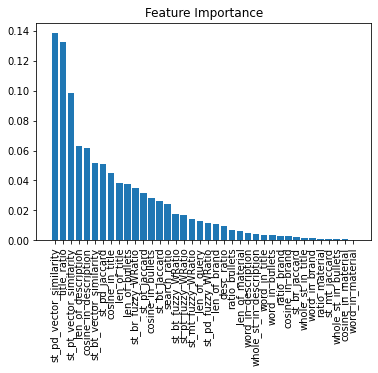

In [0]:
# Use RandomForestRegressor to check features importances

train_array=df_features.iloc[:num_train].drop(['id','relevance'],axis=1).values
target_array=df_features.relevance.iloc[:num_train].values

rf=RandomForestRegressor()
rf.fit(train_array,target_array)

importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]
names = [(df_features.drop(['id','relevance'],axis=1)).columns[i] for i in indices]
plt.figure()
plt.title("Feature Importance")
plt.bar(range(train_array.shape[1]), importances[indices])
plt.xticks(range(train_array.shape[1]), names, rotation=90)
plt.show()


In [0]:
#Split the data back to original dataframes 
#num_train takes its part now in this step 

df_train = df_features.iloc[:num_train]
df_test = df_features.iloc[num_train:]
id_test = df_test['id'] #keep the id of test data

In [0]:
################ Model Training and Evaluation ####################

In [0]:
#In following steps we will work only with the df_train
#since we will not make any only submissions to Kaggle

#Create X and y from df train 
y = df_train['relevance'].values
X = df_train.drop(['id','relevance',],axis=1).values

In [0]:
# Define the Models 

Random_Forest = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0) # Random Forest 
XGBoost = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7, silent=True) #XGBOOST
Gradient_Boost = GradientBoostingRegressor(max_depth=6,n_estimators=36) # Gradient Boosting
Linear_Regression = linear_model.LinearRegression() # Linear Regression
Ridge_Regression = Ridge(alpha=.1) # Ridge Regression

models = [Random_Forest, XGBoost, Gradient_Boost, Linear_Regression, Ridge_Regression]
names = ["Random_Forest", "XGBoost", "Gradient_Boost", "Linear_Regression", "Ridge_Regression"]

In [0]:
#Cross validation 

results_dict = {}
results =[]

for model in models:

  scores = cross_validate(model, X , y ,scoring = make_scorer(mean_squared_error) ,cv=20, verbose=1 )
  
  results_dict[names[models.index(model)]] = scores # Store resuls in dictionary for further exploitation
  
  rms = sqrt(np.mean(scores['test_score'])) # Compute rmse

  results.append(rms) # Store only rmse in a list 
  
  print(names[models.index(model)], rms)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Random_Forest 0.4697830772435398


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  7.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


XGBoost 0.4627423377427212


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  6.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Gradient_Boost 0.46431330146566957


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Linear_Regression 0.4738584692114975
Ridge_Regression 0.473858454078


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.0s finished


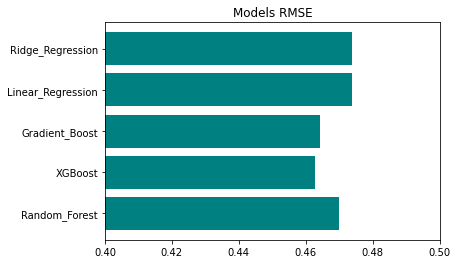

In [0]:
# Visualize the results 

y_pos = np.arange(len(names))
plt.barh(y_pos, results, color='teal')
plt.title('Models RMSE')
plt.yticks(y_pos, names)
plt.xlim([0.40,0.50])
plt.show()

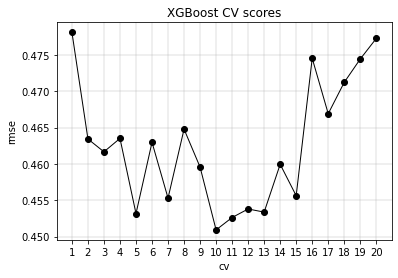

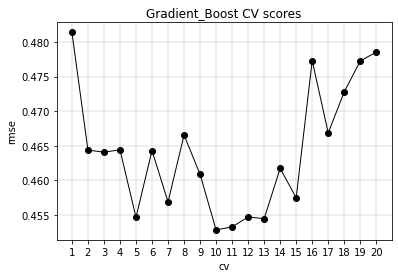

In [0]:
# Plot CV scores for XGBoost and Gradient Boost

for m in ["XGBoost", "Gradient_Boost"]:
  x = [i for i in range(1, len(results_dict[m]['test_score']) + 1)]
  y = [sqrt(i) for i in results_dict[m]['test_score']]

  plt.plot(x,y,'ko-',  linewidth=1)
  plt.xlabel('cv')
  plt.ylabel('rmse')
  plt.title(str(m) + ' CV scores')
  plt.xticks(x)
  plt.grid(linewidth = 0.4)
  plt.show()

In [0]:
#end time and print the elapsed time 
end = time.time()
print("elapsed time" , round((end-start)/60), "minutes" )

elapsed time 72 minutes
